In [2]:
import cugraph
import cudf
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
edge_list = cudf.read_csv('datasets/facebook_data.txt', delimiter=' ', names=['src', 'dst'], dtype=['int32', 'int32'])

In [4]:
G = cugraph.Graph()
G.from_cudf_edgelist(edge_list, source='src', destination='dst', store_transposed=True)

In [5]:
degrees = G.degrees()

In [6]:
print("Degrees:\n", degrees)

Degrees:
       vertex  in_degree  out_degree
0          0        347         347
1          1         17          17
2          2         10          10
3          3         17          17
4          4         10          10
...      ...        ...         ...
4034    4034          2           2
4035    4035          1           1
4036    4036          2           2
4037    4037          4           4
4038    4038          9           9

[4039 rows x 3 columns]


In [7]:
# Calculate PageRank scores
pagerank_scores = cugraph.pagerank(G)
print("Pagerank Scores:\n", pagerank_scores)

Pagerank Scores:
       vertex  pagerank
0        107  0.006888
1       1684  0.006309
2       1912  0.003817
3       3437  0.007575
4          0  0.006225
...      ...       ...
4034    4010  0.000068
4035    4015  0.000068
4036    4022  0.000068
4037    4024  0.000068
4038    4035  0.000068

[4039 rows x 2 columns]


In [8]:
# New graph with store_transposed False
G2 = cugraph.Graph()
G2.from_cudf_edgelist(edge_list, source='src', destination='dst', store_transposed=False)

In [9]:
# Calculate Betweenness Centrality Score, generally slow for large networks so better to use on subset, but I have time
betweenness_centrality_scores = cugraph.betweenness_centrality(G2)
print("Betweenness Centrality Scores: \n", betweenness_centrality_scores)

Betweenness Centrality Scores: 
       vertex  betweenness_centrality
0        107                0.480516
1       1684                0.337799
2       1912                0.229294
3       3437                0.236114
4          0                0.146305
...      ...                     ...
4034    4010                0.000000
4035    4015                0.000000
4036    4022                0.000000
4037    4024                0.000000
4038    4035                0.000000

[4039 rows x 2 columns]


In [10]:
parts, modularity_score = cugraph.louvain(G)
print(parts)
print("Modularity was found to be {}".format(modularity_score))

      vertex  partition
0        107          2
1       1684          4
2       1912          1
3       3437          5
4          0          6
...      ...        ...
4034    4010         13
4035    4015         13
4036    4022         13
4037    4024         13
4038    4035         13

[4039 rows x 2 columns]
Modularity was found to be 0.8348224759101868


In [11]:
edge_list_cpu = edge_list.to_pandas()

In [12]:
G_nx = nx.from_pandas_edgelist(edge_list_cpu, 'src', 'dst')

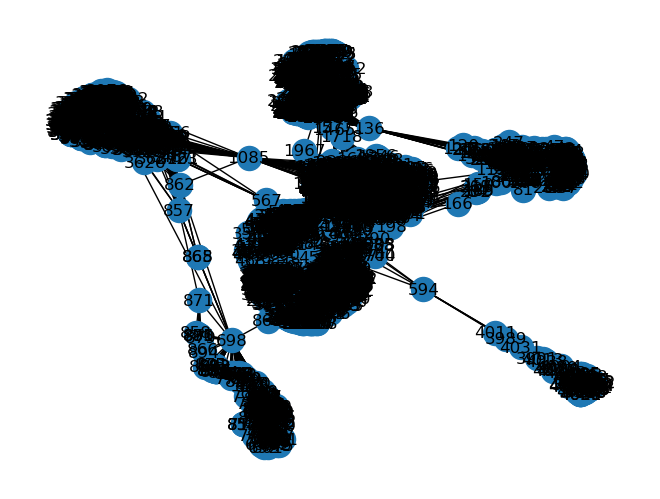

In [13]:
nx.draw(G_nx, with_labels=True)
plt.show()

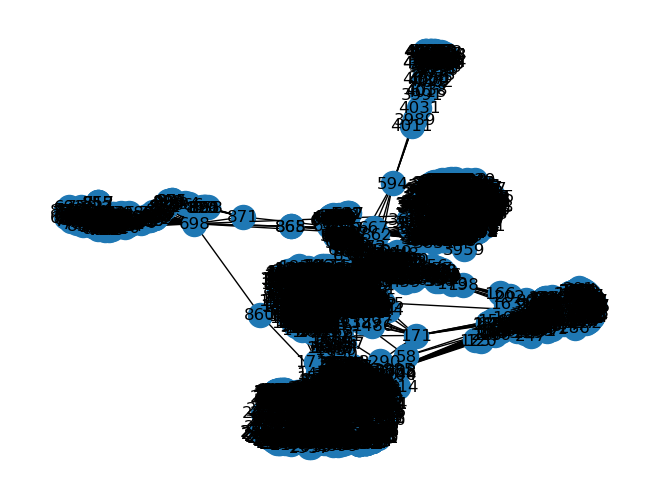

In [14]:
pos = nx.spring_layout(G_nx)  # Positions for all nodes
nx.draw(G_nx, pos, with_labels=True)
plt.show()

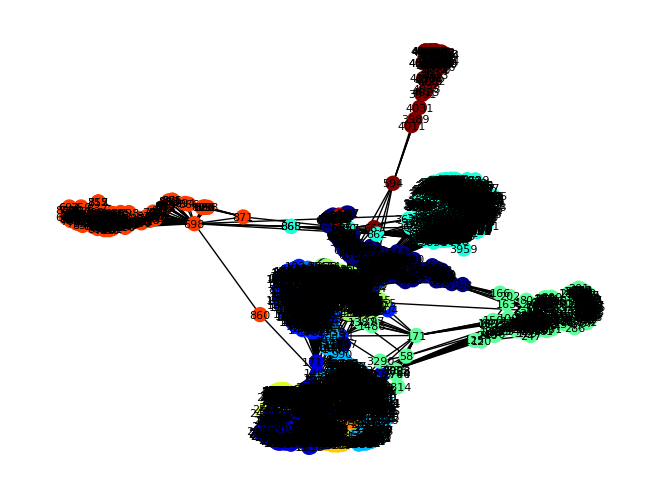

In [15]:
# Create a color map based on community membership, reusing the "pos."
community_info = parts.set_index('vertex')['partition'].to_dict()
node_color = [community_info[v] for v in G_nx.nodes()]
nx.draw(G_nx, pos, node_color=node_color, with_labels=True, cmap=plt.cm.jet, node_size=100, font_size=8)
plt.show()

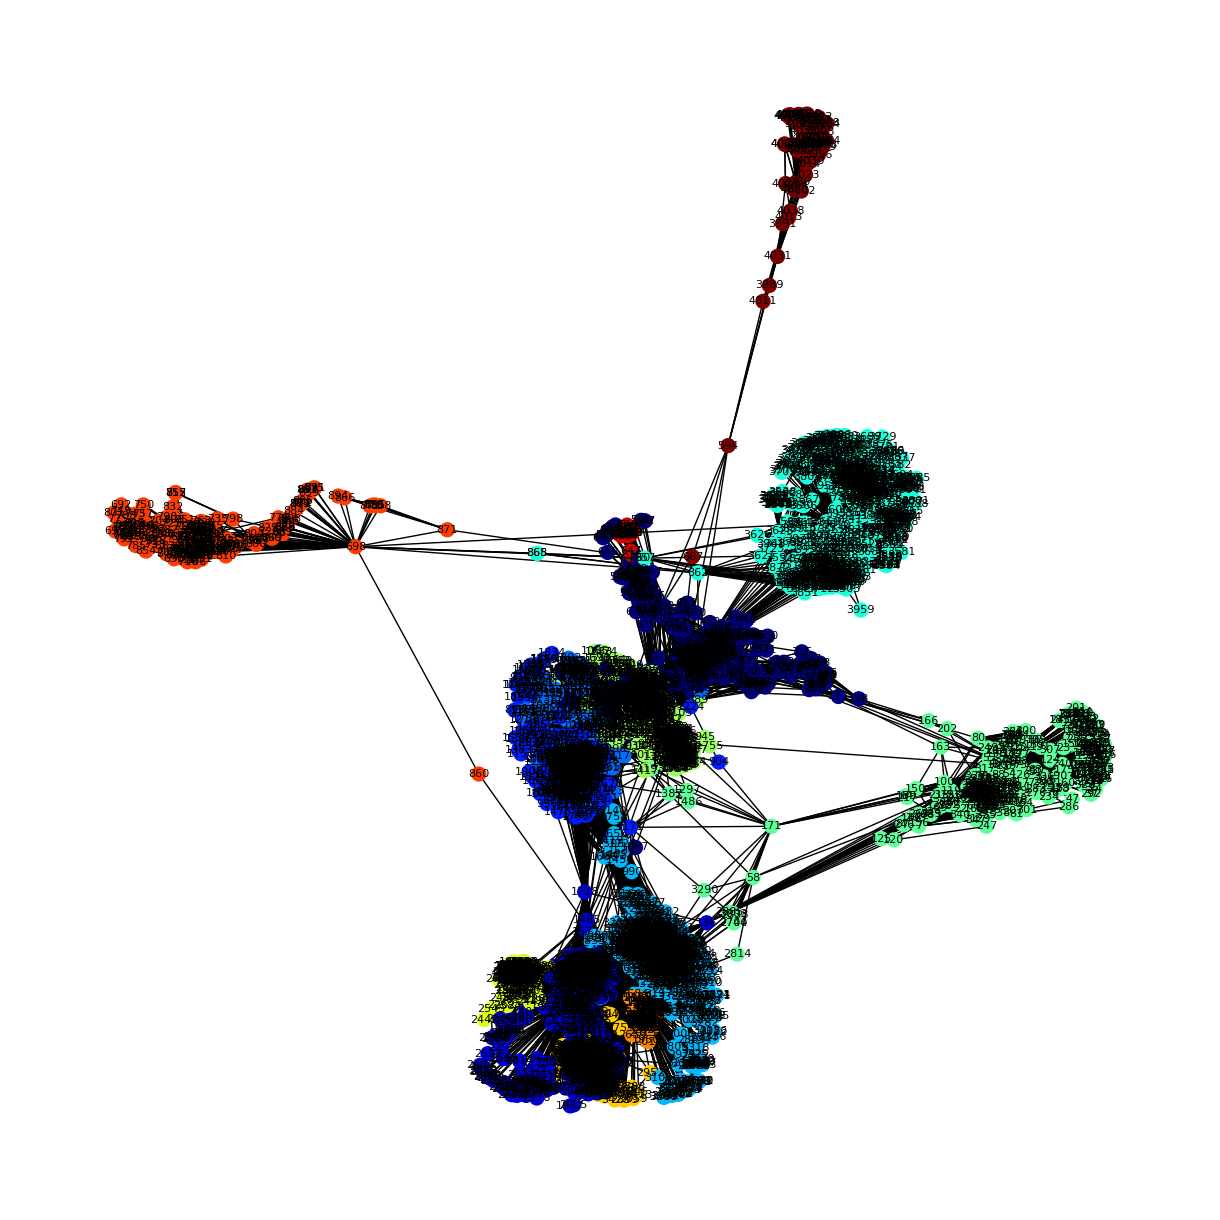

In [16]:
plt.figure(figsize=(12, 12))
nx.draw(G_nx, pos, node_color=node_color, with_labels=True, cmap=plt.cm.jet, node_size=100, font_size=8)
plt.show()

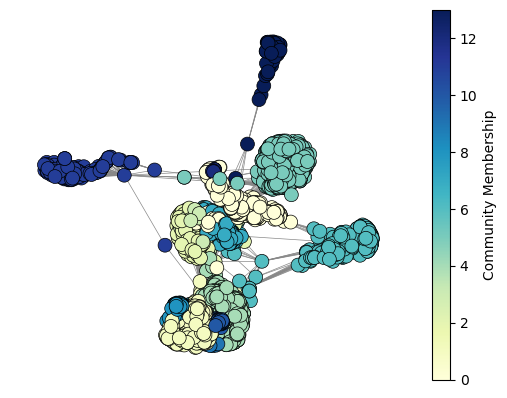

In [38]:
nx.draw_networkx_edges(G_nx, pos, edge_color="#888", width=0.5)

# Prepare color list
community_colors = [community_info[node] for node in G_nx.nodes()]

# Draw the nodes, using the community colors
nodes = nx.draw_networkx_nodes(G_nx, pos, node_color=community_colors, cmap=plt.cm.YlGnBu, node_size=100, edgecolors="k", linewidths=0.5)

# If you want a colorbar
cbar = plt.colorbar(nodes)
cbar.set_label('Community Membership')

plt.axis('off')
plt.show()

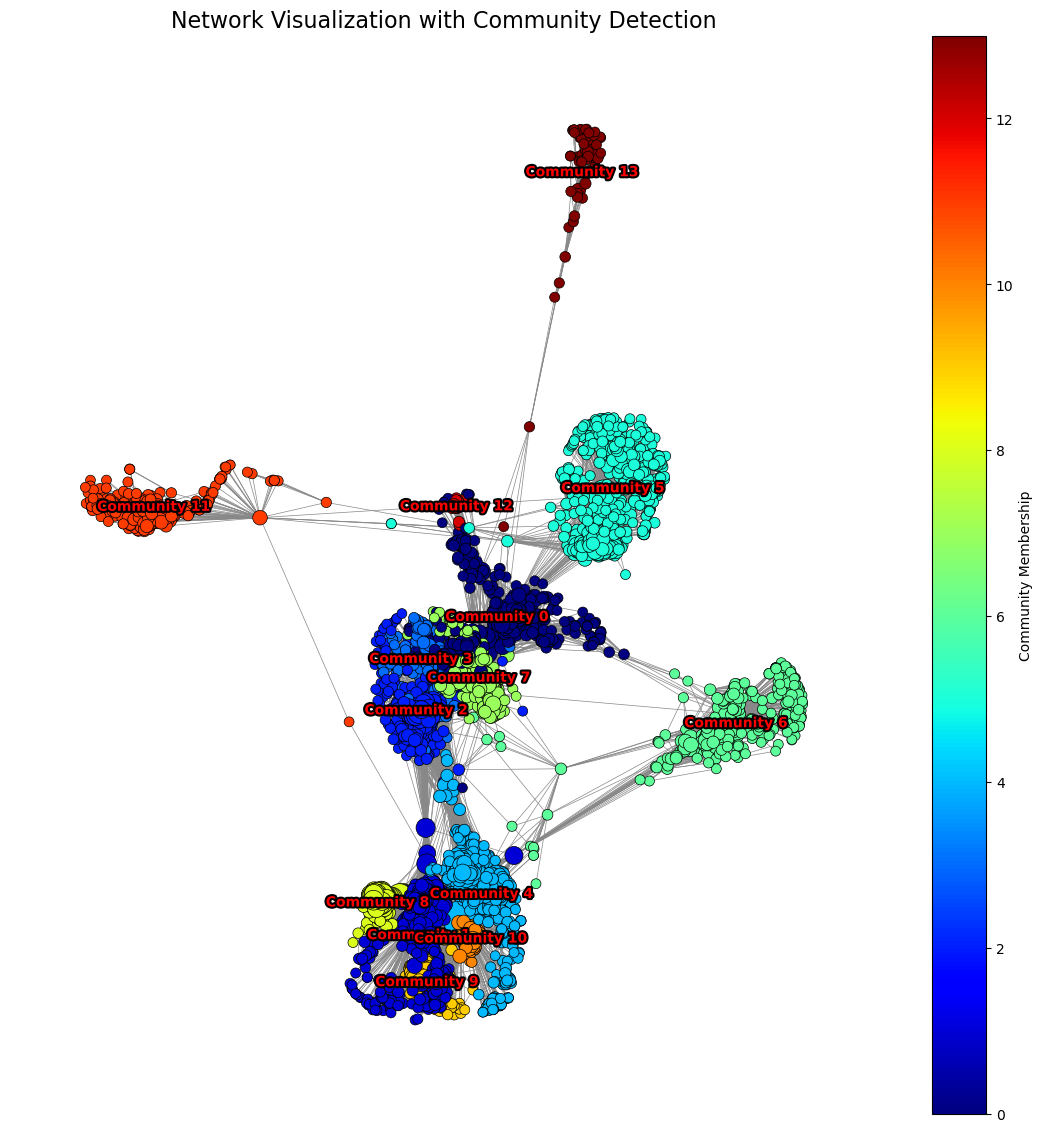

In [26]:
from collections import defaultdict
import matplotlib.patheffects as path_effects

# Assuming community_info and pos are already defined, as well as G_nx
assert 'community_info' in globals(), "community_info is not defined"
assert 'pos' in globals(), "pos is not defined"

# 1. Calculate the centroids of the communities
community_centroids = defaultdict(lambda: [0, 0, 0])  # Sum of x, sum of y, total nodes

for node, community in community_info.items():
    community_centroids[community][0] += pos[node][0]  # x position
    community_centroids[community][1] += pos[node][1]  # y position
    community_centroids[community][2] += 1  # count

# Averaging positions to find the centroid
for community, data in community_centroids.items():
    data[0] /= data[2]
    data[1] /= data[2]

# Now community_centroids contains the centroid of each community

# 2. Create community labels
community_labels = {community: f'Community {community}' for community in community_centroids}

# Create a position map for these labels
community_label_pos = {community: (data[0], data[1]) for community, data in community_centroids.items()}

plt.figure(figsize=(14, 14))

# Draw the nodes and edges as before
nodes = nx.draw_networkx_nodes(G_nx, pos, node_color=community_colors, cmap=plt.cm.jet, node_size=node_sizes, edgecolors="k", linewidths=0.5)
nx.draw_networkx_edges(G_nx, pos, edge_color="#888888", width=0.5)

# Draw community labels at the community centroids with black outline
for community, label_pos in community_label_pos.items():
    text = plt.text(label_pos[0], label_pos[1], f'Community {community}', 
                    fontsize=10, 
                    fontweight='bold', 
                    color='red', 
                    ha='center', 
                    va='center')
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                           path_effects.Normal()])

# Colorbar and other visual elements
cbar = plt.colorbar(nodes)
cbar.set_label('Community Membership')

plt.title('Network Visualization with Community Detection', fontsize=16)
plt.axis('off')
plt.show()

In [28]:
assert 'pagerank_scores' in globals(), "pagerank_scores is not defined"

In [29]:
pagerank_dict = pagerank_scores.set_index('vertex')['pagerank'].to_dict()


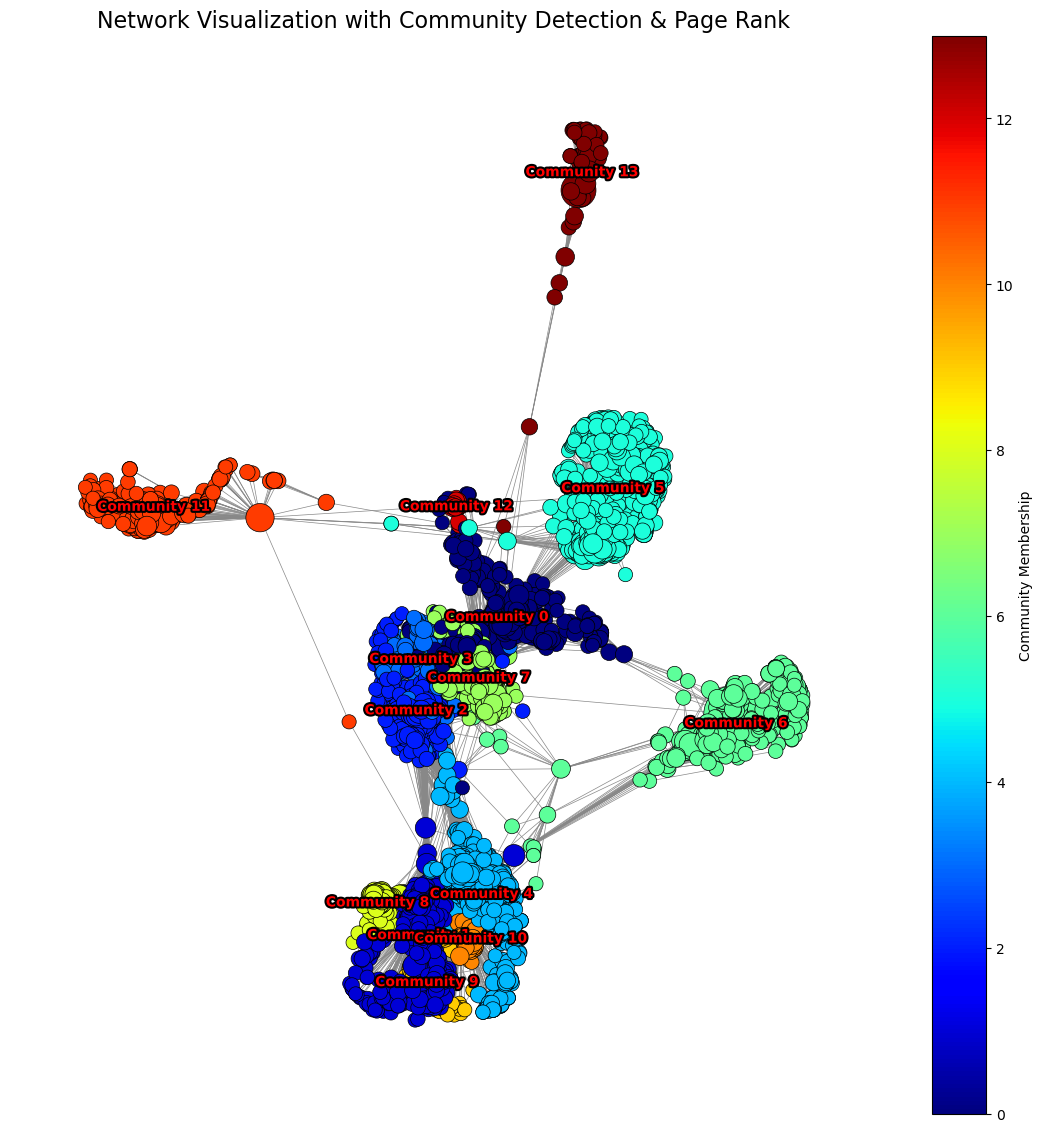

In [35]:
min_pr = min(pagerank_dict.values())
max_pr = max(pagerank_dict.values())

# The node size needs a float value, and the PageRank provides a very small float, 
# so you may want to scale the sizes to make them visible.
node_sizes = [100 + 1900 * ((pagerank_dict[node] - min_pr) / (max_pr - min_pr)) for node in G_nx.nodes()]

plt.figure(figsize=(14, 14))

# Draw the graph, specifying node sizes
nodes = nx.draw_networkx_nodes(G_nx, pos, node_color=community_colors, cmap=plt.cm.jet, node_size=node_sizes, edgecolors="k", linewidths=0.5)
nx.draw_networkx_edges(G_nx, pos, edge_color="#888888", width=0.5)

# Draw community labels at the centroids
for community, label_pos in community_label_pos.items():
    text = plt.text(label_pos[0], label_pos[1], f'Community {community}', 
                    fontsize=10, 
                    fontweight='bold', 
                    color='red', 
                    ha='center', 
                    va='center')
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                           path_effects.Normal()])

# Colorbar and other visual enhancements
cbar = plt.colorbar(nodes)
cbar.set_label('Community Membership')

plt.title('Network Visualization with Community Detection & Page Rank', fontsize=16)
plt.axis('off')
plt.show()


In [31]:
assert 'betweenness_centrality_scores' in globals(), "betweenness_centrality_scores is not defined"

In [32]:
# Adjust the column names if they're different in your DataFrame.
betweenness_dict = betweenness_centrality_scores.set_index('vertex')['betweenness_centrality'].to_dict()

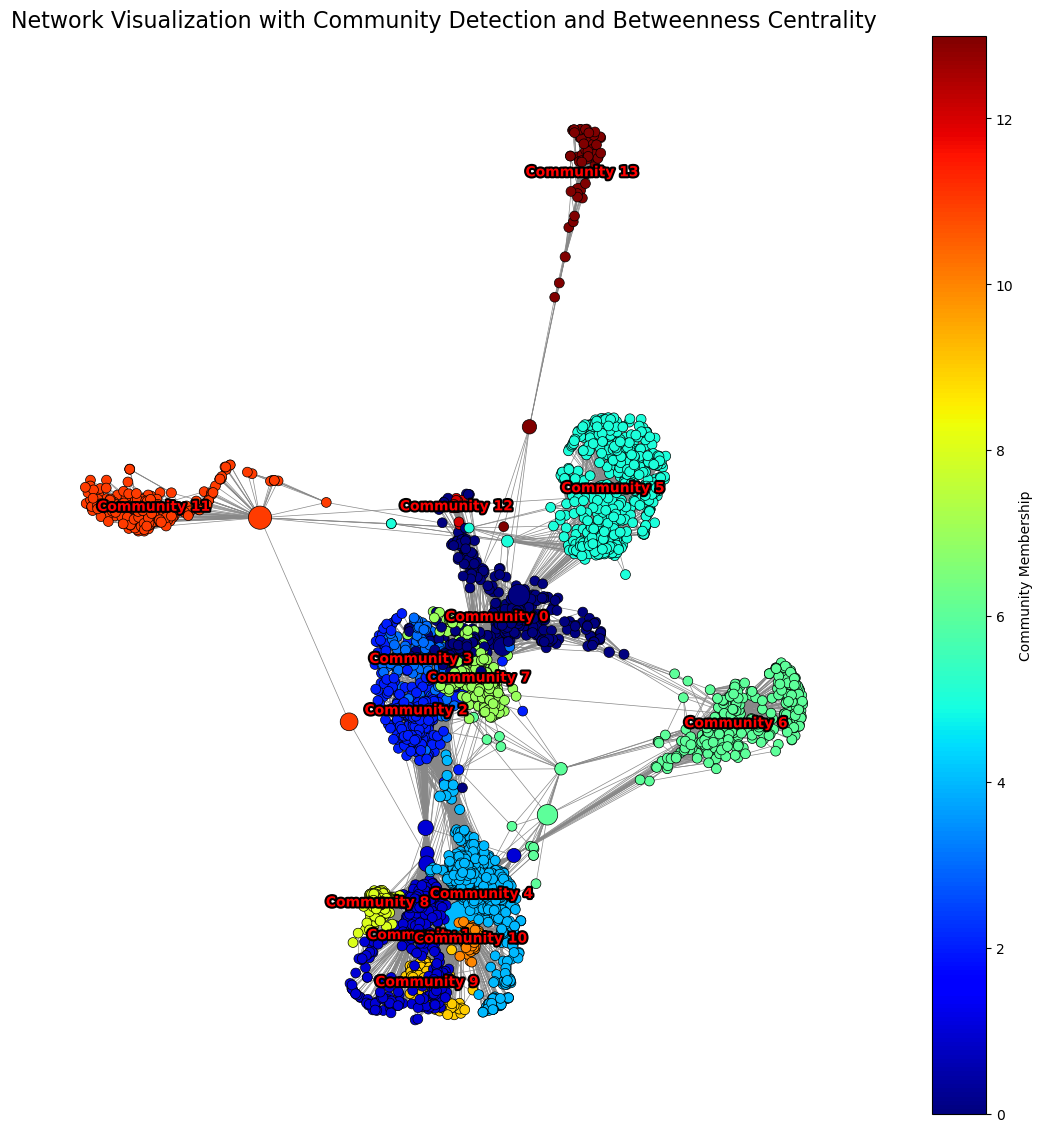

In [36]:
min_betweenness = min(betweenness_dict.values())
max_betweenness = max(betweenness_dict.values())

# Scale betweenness values for visualization purposes. Nodes with higher betweenness are typically more central in the network.
node_sizes = [50 + 950 * ((betweenness_dict[node] - min_betweenness) / (max_betweenness - min_betweenness)) for node in G_nx.nodes()]

plt.figure(figsize=(14, 14))

# Draw the nodes, specifying the node sizes based on betweenness centrality
nodes = nx.draw_networkx_nodes(G_nx, pos, node_color=community_colors, cmap=plt.cm.jet, node_size=node_sizes, edgecolors="k", linewidths=0.5)
nx.draw_networkx_edges(G_nx, pos, edge_color="#888888", width=0.5)

# Add community labels at their centroids with visual enhancements
for community, label_pos in community_label_pos.items():
    text = plt.text(label_pos[0], label_pos[1], f'Community {community}', 
                    fontsize=10, 
                    fontweight='bold', 
                    color='red', 
                    ha='center', 
                    va='center')
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                           path_effects.Normal()])

# Include colorbar and other visual elements for a polished look
cbar = plt.colorbar(nodes)
cbar.set_label('Community Membership')

plt.title('Network Visualization with Community Detection and Betweenness Centrality', fontsize=16)
plt.axis('off')
plt.show()
